In [1]:
!git clone https://github.com/helpingstar/gym-woodoku.git
%cd gym-woodoku
%pip install -e . -q

c:\Users\WooSeong\RL-application\gym-woodoku


Cloning into 'gym-woodoku'...


Note: you may need to restart the kernel to use updated packages.


In [18]:
from tqdm import tqdm
import matplotlib.pyplot as plt
import gym_woodoku
import gym
from gym import spaces
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import random

In [19]:
torch.device("cuda" if torch.cuda.is_available() else "cpu")

device(type='cuda')

In [28]:
# input.shape : (15, 15)
class DQN(nn.Module):
    def __init__(self,
                 observation_space: spaces.MultiBinary,
                 action_space: spaces.Discrete):
        super().__init__()
        assert type(
            observation_space) == spaces.MultiBinary, 'observation_space must be of type Box'
        assert len(
            observation_space.shape) == 3, 'observation space must have the form channels x width x height'
        assert type(
            action_space) == spaces.Discrete, 'action_space must be of type Discrete'
        
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5, stride=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1),
            nn.ReLU()
        )

        self.fc = nn.Sequential(
            nn.Linear(in_features=64*7*7 , out_features=512),
            nn.ReLU(),
            nn.Linear(in_features=512, out_features=action_space.n)
        )

    def forward(self, x):
        conv_out = self.conv(x).view(x.size()[0],-1)
        return self.fc(conv_out)

In [29]:
import numpy as np


class ReplayBuffer:
    """
    Simple storage for transitions from an environment.
    """

    def __init__(self, size):
        """
        Initialise a buffer of a given size for storing transitions
        :param size: the maximum number of transitions that can be stored
        """
        self._storage = []
        self._maxsize = size
        self._next_idx = 0

    def __len__(self):
        return len(self._storage)

    def add(self, state, action, reward, next_state, done):
        """
        Add a transition to the buffer. Old transitions will be overwritten if the buffer is full.
        :param state: the agent's initial state
        :param action: the action taken by the agent
        :param reward: the reward the agent received
        :param next_state: the subsequent state
        :param done: whether the episode terminated
        """
        data = (state, action, reward, next_state, done)

        if self._next_idx >= len(self._storage):
            self._storage.append(data)
        else:
            self._storage[self._next_idx] = data
        self._next_idx = (self._next_idx + 1) % self._maxsize

    def _encode_sample(self, indices):
        states, actions, rewards, next_states, dones = [], [], [], [], []
        for i in indices:
            data = self._storage[i]
            state, action, reward, next_state, done = data
            states.append(np.array(state, copy=False))
            actions.append(action)
            rewards.append(reward)
            next_states.append(np.array(next_state, copy=False))
            dones.append(done)
        return np.array(states), np.array(actions), np.array(rewards), np.array(next_states), np.array(dones)

    def sample(self, batch_size):
        """
        Randomly sample a batch of transitions from the buffer.
        :param batch_size: the number of transitions to sample
        :return: a mini-batch of sampled transitions
        """
        indices = np.random.randint(0, len(self._storage) - 1, size=batch_size)
        return self._encode_sample(indices)

In [30]:
class DQNAgent:
    def __init__(self,
                 observation_space: spaces.MultiBinary,
                 action_space: spaces.Discrete,
                 replay_buffer: ReplayBuffer,
                 lr,
                 batch_size,
                 gamma,
                 device=torch.device("cpu" )):
        """
        Initialise the DQN algorithm using the Adam optimiser
        :param action_space: the action space of the environment
        :param observation_space: the state space of the environment
        :param replay_buffer: storage for experience replay
        :param lr: the learning rate for Adam
        :param batch_size: the batch size
        :param gamma: the discount factor
        """

        self.memory = replay_buffer
        self.batch_size = batch_size
        self.gamma = gamma

        self.policy_network = DQN(observation_space, action_space).to(device)
        self.target_network = DQN(observation_space, action_space).to(device)
        self.update_target_network()
        self.target_network.eval()

        self.optimiser = torch.optim.RMSprop(self.policy_network.parameters()
            , lr=lr)        
        ## self.optimiser = torch.optim.Adam(self.policy_network.parameters(), lr=lr)

        self.device = device

    def optimise_td_loss(self):
        """
        Optimise the TD-error over a single minibatch of transitions
        :return: the loss
        """
        device = self.device

        states, actions, rewards, next_states, dones = self.memory.sample(self.batch_size)
        states = torch.from_numpy(states).float().to(device)
        actions = torch.from_numpy(actions).long().to(device)
        rewards = torch.from_numpy(rewards).float().to(device)
        next_states = torch.from_numpy(next_states).float().to(device)
        dones = torch.from_numpy(dones).float().to(device)

        with torch.no_grad():
            next_q_values = self.target_network(next_states)
            max_next_q_values, _ = next_q_values.max(1)
            target_q_values = rewards + (1 - dones) * self.gamma * max_next_q_values

        input_q_values = self.policy_network(states)
        input_q_values = input_q_values.gather(1, actions.unsqueeze(1)).squeeze()

        loss = F.smooth_l1_loss(input_q_values, target_q_values)

        self.optimiser.zero_grad()
        loss.backward()
        self.optimiser.step()
        del states
        del next_states
        return loss.item()

    def update_target_network(self):
        """
        Update the target Q-network by copying the weights from the current Q-network
        """
        self.target_network.load_state_dict(self.policy_network.state_dict())

    def act(self, state: np.ndarray):
        """
        Select an action greedily from the Q-network given the state
        :param state: the current state
        :return: the action to take
        """
        device = self.device
        state = np.array(state)
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        with torch.no_grad():
            q_values = self.policy_network(state)
            _, action = q_values.max(1)
            return action.item()

In [31]:
class PyTorchFrame(gym.ObservationWrapper):
    """Image shape to num_channels x height x width"""

    def __init__(self, env):
        super(PyTorchFrame, self).__init__(env)
        shape = self.observation_space.shape
        self.observation_space = gym.spaces.MultiBinary([shape[-1], shape[0], shape[1]])

    def observation(self, observation):
        return np.rollaxis(observation, 2)
    
class MultiplyReward(gym.RewardWrapper):
    def __init__(self, env, ratio):
        super().__init__(env)
        self.ratio = ratio

    def reward(self, reward):
        return reward * self.ratio

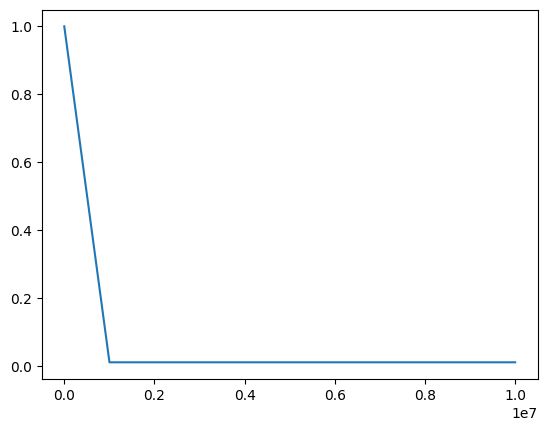

In [32]:
import matplotlib.pyplot as plt

h_num_steps = int(1e7)

thres_list = []

def linear_epsilon_decrease(now_step, total_step, max_eps=1, min_eps=0.1, ratio=0.1):
    eps_timesteps = ratio * float(total_step)
    fraction = min(1.0, float(now_step) / eps_timesteps)
    eps = max_eps + fraction * (min_eps - max_eps)
    return eps

for i in range(h_num_steps):
    thres_list.append(linear_epsilon_decrease(i, h_num_steps, 1, 0.01, 0.1))

plt.plot(thres_list)


In [33]:
EPISODE_NUM = 5000
SEED_NUM = 20
TOTAL_STEP = 10000000

MAX_EPSILON = 1.0
MIN_EPSILON = 0.1
env = gym.make('gym_woodoku/Woodoku-v0', game_mode='woodoku')
env = PyTorchFrame(env)
env = MultiplyReward(env, 0.1)


replay_buffer = ReplayBuffer(10000)

agent = DQNAgent(env.observation_space,
                 env.action_space,
                 replay_buffer,
                 lr=1e-4,
                 batch_size=64,
                 gamma=0.999,
                 device=torch.device("cuda" if torch.cuda.is_available() else "cpu"))

state, _ = env.reset()
score = []
episode_rewards = [0.0]
step_count = 0
for t in tqdm(range(TOTAL_STEP)):
    sample = random.random()
    epsilon = linear_epsilon_decrease(t, TOTAL_STEP, max_eps=1, min_eps=0.01, ratio=0.3)
    if sample > epsilon:
        # Exploit
        action = agent.act(state)
    else:
        # Explore
        action = env.action_space.sample()
    next_state, reward, terminated, truncated, info = env.step(action)
    agent.memory.add(next_state, action, reward, next_state, float(terminated))
    state = next_state
    episode_rewards[-1] += reward

    if terminated:
        state, _ = env.reset()
        episode_rewards.append(0.0)
        if len(episode_rewards) % 50 == 0:
            print(sum(episode_rewards[-10:])/10)

    if t > 10000:
        agent.optimise_td_loss()

    if t > 10000 and t % 500 == 0:
        agent.update_target_network()

  0%|          | 22097/10000000 [00:56<12:23:20, 223.72it/s]

6.5200000000000005


  0%|          | 44294/10000000 [02:42<13:43:27, 201.50it/s]

6.720000000000001


  1%|          | 63558/10000000 [04:12<16:35:25, 166.37it/s]

5.28


  1%|          | 85567/10000000 [05:51<11:54:32, 231.25it/s]

6.590000000000001


  1%|          | 107495/10000000 [07:28<12:20:39, 222.60it/s]

6.69


  1%|▏         | 127736/10000000 [08:57<12:48:48, 214.02it/s]

6.25


  1%|▏         | 146309/10000000 [10:21<12:53:10, 212.41it/s]

5.06


  2%|▏         | 167318/10000000 [12:01<12:10:36, 224.30it/s]

4.61


  2%|▏         | 187896/10000000 [13:37<12:52:15, 211.76it/s]

5.5200000000000005


  2%|▏         | 207303/10000000 [15:07<12:25:22, 218.97it/s]

6.110000000000001


  2%|▏         | 227149/10000000 [16:42<13:30:48, 200.89it/s]

6.340000000000001


  3%|▎         | 251480/10000000 [18:34<14:24:09, 188.02it/s]

7.2700000000000005


  3%|▎         | 278633/10000000 [20:42<13:08:33, 205.47it/s]

8.19


  3%|▎         | 296379/10000000 [22:04<12:25:52, 216.83it/s]

5.96


  3%|▎         | 323150/10000000 [24:08<12:00:49, 223.74it/s]

6.220000000000001


  3%|▎         | 344692/10000000 [25:49<13:25:06, 199.88it/s]

7.250000000000002


  4%|▎         | 366770/10000000 [27:34<12:57:24, 206.53it/s]

7.6800000000000015


  4%|▍         | 395595/10000000 [29:54<13:07:56, 203.15it/s]

19.559999999999995


  4%|▍         | 417061/10000000 [31:42<12:31:26, 212.55it/s]

5.659999999999999


  4%|▍         | 442960/10000000 [33:50<12:25:13, 213.74it/s]

6.5200000000000005


  5%|▍         | 464564/10000000 [35:31<11:23:06, 232.65it/s]

8.330000000000002


  5%|▍         | 485844/10000000 [37:10<12:04:36, 218.83it/s]

8.440000000000001


  5%|▌         | 514346/10000000 [39:25<12:16:14, 214.73it/s]

5.630000000000001


  5%|▌         | 542050/10000000 [41:38<13:46:49, 190.65it/s]

7.630000000000001


  6%|▌         | 565932/10000000 [43:30<11:30:31, 227.70it/s]

5.88


  6%|▌         | 583499/10000000 [44:48<11:48:29, 221.51it/s]

4.45


  6%|▌         | 612485/10000000 [46:57<11:42:09, 222.83it/s]

4.569999999999999


  6%|▋         | 635751/10000000 [48:40<11:20:19, 229.40it/s]

5.680000000000001


  7%|▋         | 667477/10000000 [51:00<11:07:10, 233.13it/s]

12.820000000000002


  7%|▋         | 690466/10000000 [52:41<11:13:33, 230.36it/s]

5.67


  7%|▋         | 710789/10000000 [54:11<11:04:49, 232.87it/s]

4.950000000000001


  7%|▋         | 730342/10000000 [55:37<11:12:08, 229.86it/s]

5.109999999999999


  8%|▊         | 755101/10000000 [57:30<12:00:40, 213.80it/s]

9.209999999999999


  8%|▊         | 785127/10000000 [59:44<11:50:17, 216.22it/s]

10.24


  8%|▊         | 807772/10000000 [1:01:25<11:06:32, 229.85it/s]

6.910000000000001


  8%|▊         | 835030/10000000 [1:03:25<11:04:23, 229.91it/s]

5.9


  9%|▊         | 855237/10000000 [1:04:52<11:09:41, 227.59it/s]

5.64


  9%|▉         | 879991/10000000 [1:06:38<11:06:22, 228.10it/s]

9.86


  9%|▉         | 906961/10000000 [1:08:33<10:58:43, 230.07it/s]

7.92


  9%|▉         | 936351/10000000 [1:10:40<10:19:06, 244.00it/s]

5.92


 10%|▉         | 964594/10000000 [1:12:42<10:42:57, 234.21it/s]

7.1800000000000015


 10%|▉         | 989431/10000000 [1:14:29<11:10:02, 224.13it/s]

5.69


 10%|█         | 1017700/10000000 [1:16:30<10:34:24, 235.98it/s]

9.690000000000001


 10%|█         | 1044130/10000000 [1:18:24<11:17:17, 220.38it/s]

7.99


 11%|█         | 1070569/10000000 [1:20:18<10:30:18, 236.11it/s]

5.430000000000001


 11%|█         | 1102432/10000000 [1:22:38<11:32:36, 214.11it/s]

8.39


 11%|█         | 1124659/10000000 [1:24:26<11:29:10, 214.64it/s]

4.7299999999999995


 12%|█▏        | 1150513/10000000 [1:26:31<12:05:59, 203.16it/s]

In [ ]:
sum(episode_rewards) / len(episode_rewards)

75.15414258188825

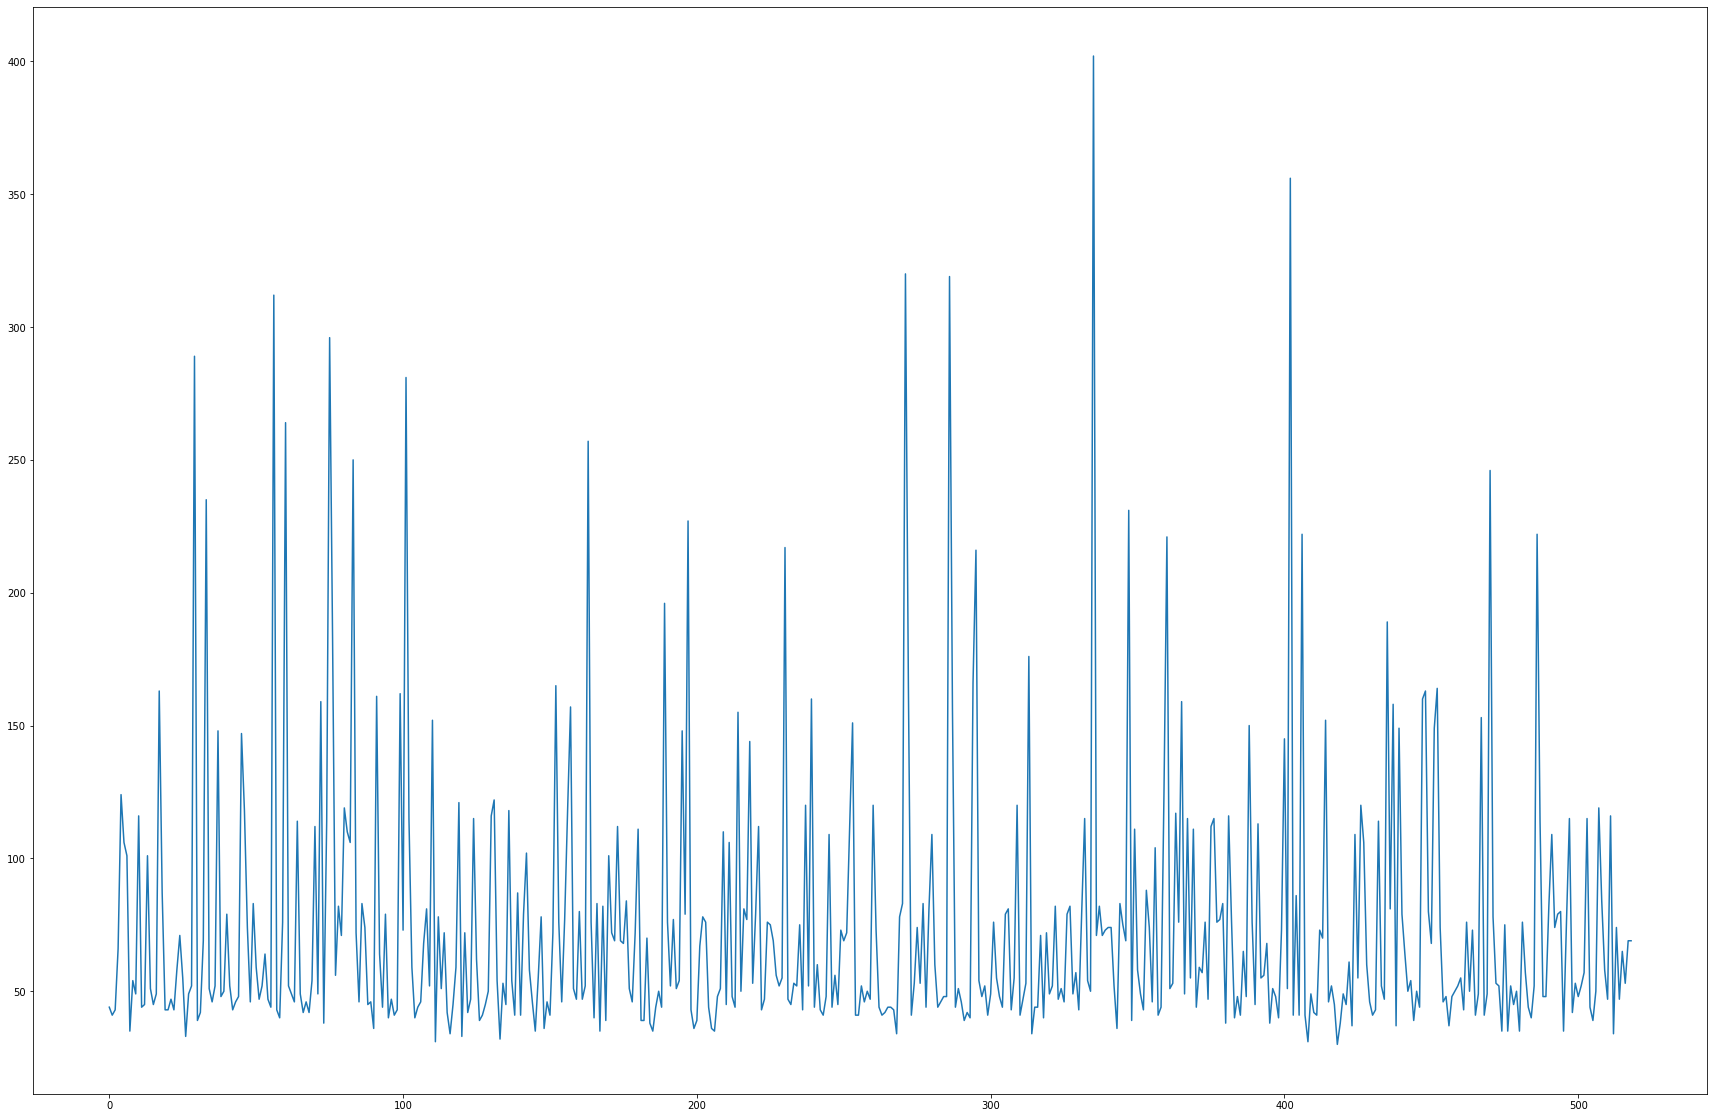

In [ ]:
plt.figure(figsize=(30, 20))
plt.plot(episode_rewards)